# Financial News Sentiment Analysis for Stock Prediction  
### Team 114: Aryan Mehta & Vedashree Bane
---

## Project Workflow

**STEP 1: Stock Data Prep**  
   - Download 2019 stock data for top-10 tickers (to minimize the scope for this project)
   - Compute daily returns, price change, rolling MAs, volatility
<br />

**STEP 2: News Ingestion & Cleaning**  
   - Load Reuters headlines + descriptions  
   - Lowercase, strip punctuation, remove stopwords  
<br />

**STEP 3: Sentiment Scoring**  
   - Run VADER (rule-based) and FinBERT (financial transformer)  
   - Weight headlines vs. descriptions (70/30), blend scores  
   - Map into three labels: −1 (negative), 0 (neutral), +1 (positive)  
<br />

**STEP 4: Data Merge**  
   - Match articles to company tickers and trading dates  
   - Inner-join sentiment with stock features  
<br />

**STEP 5: Modeling**  
   - Train and tune a Random Forest (with median imputation)  
   - Evaluate via classification report, confusion matrix  
<br />

**STEP 6: Visualization**  
   - Plot feature importances  
   - Display correlation heatmap of features vs. price movement  
<br />

**STEP 7: Reusable Functions**  
   - Encapsulate preprocessing, scoring, and prediction logic  
<br />

**STEP 8: Live Inference**  
   - Fetch recent news via NewsAPI, get live prices  
   - Compute sentiment, predict UP/DOWN, estimate next-day close

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime

In [2]:
# Define top 10 tickers and date range
top_companies = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'NVDA', 'META', 'NFLX', 'JNJ', 'V']
start_date = '2018-11-18'
end_date   = '2019-12-31'

stock_frames = []
for symbol in top_companies:
    df = yf.Ticker(symbol).history(start=start_date, end=end_date)
    if df.empty:
        print(f"Warning: no data for {symbol}")
        continue
    df = df[['Open','Close','High','Low','Volume','Dividends','Stock Splits']].copy()
    df['Date'] = df.index
    df['Company'] = symbol

    # feature engineering
    df['Price_Change']       = df['Close'] - df['Open']
    df['Daily_Return']       = df['Close'].pct_change()
    df['7_day_MA']           = df['Close'].rolling(7).mean()
    df['30_day_MA']          = df['Close'].rolling(30).mean()
    df['50_day_MA']          = df['Close'].rolling(50).mean()
    df['Rolling_Volatility'] = df['Close'].rolling(30).std()

    stock_frames.append(df.reset_index(drop=True))

# concatenate all companies
stock_df = pd.concat(stock_frames, ignore_index=True)
stock_df.fillna(method='ffill', inplace=True)
stock_df.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], inplace = True)
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.strftime('%Y-%m-%d')

/var/folders/zn/ssbtl9ws7txg5dlk5r5mw0340000gn/T/ipykernel_82997/1184631512.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df.fillna(method='ffill', inplace=True)


In [3]:
# stock_df = stock_df.iloc[50:].reset_index(drop=True)

In [4]:
stock_df.shape

(2790, 9)

In [5]:
stock_df.head()

,Close,Date,Company,Price_Change,Daily_Return,7_day_MA,30_day_MA,50_day_MA,Rolling_Volatility
0,44.331455,2018-11-19,AAPL,-0.987476,NaN,NaN,NaN,NaN,NaN
1,42.213387,2018-11-20,AAPL,-0.331544,-0.047778,NaN,NaN,NaN,NaN
2,42.165684,2018-11-21,AAPL,-0.703635,-0.001130,NaN,NaN,NaN,NaN
3,41.094727,2018-11-23,AAPL,-0.632082,-0.025399,NaN,NaN,NaN,NaN
4,41.650475,2018-11-26,AAPL,0.090635,0.013524,NaN,NaN,NaN,NaN


## 2. News Data Ingestion & Preprocessing

In this cell we will:

1. Load the Reuters headlines CSV.
2. Parse the publication dates and filter only 2019.
3. Check for any missing days.
4. Clean the `Headlines` and `Description` text by lowercasing, stripping punctuation, and removing English stopwords.

In [6]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download NLTK resources (only need to do this once)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/aryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# 1. Load the Reuters dataset
news_df = pd.read_csv('reuters_headlines.csv')

# 2. Parse dates and filter for 2019
news_df['Time'] = pd.to_datetime(news_df['Time'], format='%b %d %Y')
news_df = news_df[news_df['Time'].dt.year == 2019] \
                 .sort_values('Time') \
                 .reset_index(drop=True)

# 3. (Optional) Check for missing dates in 2019
all_dates = pd.date_range('2019-01-01', '2019-12-31', freq='D')
missing = set(all_dates.date) - set(news_df['Time'].dt.date)
print(f"Missing dates in 2019: {len(missing)}")  # ideally 0

# 4. Define a preprocessing function
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    return ' '.join([t for t in tokens if t not in stop_words])

# 5. Apply cleaning to both columns
news_df['Clean_Headlines']   = news_df['Headlines'].apply(preprocess_text)
news_df['Clean_Description'] = news_df['Description'].apply(preprocess_text)

Missing dates in 2019: 0


In [8]:
# Preview
news_df[['Time','Clean_Headlines','Clean_Description']].head()

,Time,Clean_Headlines,Clean_Description
0,2019-01-01,exclusive netflix poaches cfo activision blizz...,netflix inc expected announce next days poache...
1,2019-01-01,china december factory activity shrinks first ...,chinas factory activity contracted first time ...
2,2019-01-01,big banks look cut back alter credit card rewa...,large financial institutions including jp morg...
3,2019-01-01,fatalities commercial passenger aircraft rise ...,fatality rate passenger jet aircraft worldwide...
4,2019-01-02,warren buffett sinking apple shares wish come ...,billionaire warren buffett said would love see...


In [9]:
# news_df_copy = news_df

In [10]:
# news_df = news_df[:20000]

In [11]:
news_df.shape

(13696, 5)

## 4. Sentiment Analysis (VADER + FinBERT)

In this cell we compute sentiment scores for each cleaned headline and description using two complementary techniques:

1. **Initialize models**  
   - **VADER**: A rule‐based sentiment analyzer optimized for short social media–style text.  
   - **FinBERT**: A transformer model fine-tuned on financial news to capture domain-specific sentiment nuances.

2. **Scoring functions**  
   - `vader_score(text)` returns the VADER compound score (−1 to +1).  
   - `finbert_score(text)` uses the FinBERT pipeline to get a POSITIVE or NEGATIVE probability, converting it to a signed score.

3. **Apply to our DataFrame**  
   - Compute VADER and FinBERT scores separately for **headlines** and **descriptions**.  

4. **Combine within each model**  
   - Weight headline more heavily:  
     - `Sent_VADER   = 0.7 * Head_vader   + 0.3 * Desc_vader`  
     - `Sent_FinBERT = 0.7 * Head_finbert + 0.3 * Desc_finbert`  

5. **Blend the two models**  
   - `Combined_Sentiment = (Sent_VADER + Sent_FinBERT) / 2`
     ```

6. **Preview the results**  
   - Display the date, cleaned headline, individual scores, combined sentiment, and final label for the first few rows.

#### Sentiment Labeling with Negative, Neutral & Positive

We’ll have used a three-way label so that:
- **−1** means clearly negative sentiment  
- **0** means neutral/mixed sentiment  
- **+1** means clearly positive sentiment  

To do this:
1. We choose small thresholds around zero to define “neutral.”  
2. Map the continuous `Combined_Sentiment` into {−1, 0, +1}.  
3. Use that new `Sentiment_Label` in downstream modeling.  

This gives our model a chance to treat “no strong lean” differently from mildly positive or negative news.  

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import numpy as np

In [13]:
# 1. Initialize VADER
sid = SentimentIntensityAnalyzer()

# 2. Initialize FinBERT pipeline
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use mps:0


In [14]:
# 3. Define scoring functions
def vader_score(text):
    return sid.polarity_scores(text)['compound']

def finbert_score(text):
    out = finbert_pipeline(text)[0]
    label, score = out['label'], out['score']
    return  score if label=="POSITIVE" else -score if label=="NEGATIVE" else 0.0

In [15]:
# 4. Apply to cleaned headlines & descriptions
news_df['Head_vader'] = news_df['Clean_Headlines'].apply(vader_score)
news_df['Desc_vader'] = news_df['Clean_Description'].apply(vader_score)
news_df['Head_finbert'] = news_df['Clean_Headlines'].apply(finbert_score)
news_df['Desc_finbert'] = news_df['Clean_Description'].apply(finbert_score)

In [16]:
# 5. Weighted combinations (70% headline, 30% description)
news_df['Sent_VADER'] = news_df['Head_vader'] * 0.7 + news_df['Desc_vader'] * 0.3
news_df['Sent_FinBERT'] = news_df['Head_finbert'] * 0.7 + news_df['Desc_finbert'] * 0.3

In [17]:
# 6. Final combined sentiment and label
news_df['Combined_Sentiment'] = (news_df['Sent_VADER'] + news_df['Sent_FinBERT']) / 2
news_df['Sentiment_Label'] = np.where(news_df['Combined_Sentiment'] > 0, 1, 0)

In [18]:
# 7. Bin into −1, 0, +1 using ±0.1 thresholds
pos_thr, neg_thr =  0.03, -0.03
def three_way_label(x):
    if x >  pos_thr: return  1   # positive
    if x <  neg_thr: return -1   # negative
    return 0                     # neutral

news_df['Sentiment_Label'] = news_df['Combined_Sentiment'].apply(three_way_label)

In [19]:
# 8. Preview results
news_df[['Time','Clean_Headlines','Sent_VADER','Sent_FinBERT','Combined_Sentiment','Sentiment_Label']].head()

,Time,Clean_Headlines,Sent_VADER,Sent_FinBERT,Combined_Sentiment,Sentiment_Label
0,2019-01-01,exclusive netflix poaches cfo activision blizz...,0.09734,0.0,0.048670,1
1,2019-01-01,china december factory activity shrinks first ...,-0.12645,0.0,-0.063225,-1
2,2019-01-01,big banks look cut back alter credit card rewa...,0.60570,0.0,0.302850,1
3,2019-01-01,fatalities commercial passenger aircraft rise ...,-0.62967,0.0,-0.314835,-1
4,2019-01-02,warren buffett sinking apple shares wish come ...,0.79345,0.0,0.396725,1


## 5. Match News Articles to Stock Data & Merge

In this cell we link each news item to the corresponding stock record for the same date and company:

1. **Define ticker variants**  
   We create a dictionary of common name variations for each of our 10 companies (e.g. “apple”, “apple inc”, “AAPL”).

2. **Extract tickers from headlines**  
   The `match_tickers()` function scans each cleaned headline for any of these variants and returns a list of matching tickers.

3. **Prepare for merging**  
   - Convert the publication `Time` to a `Date` string.  
   - Explode the DataFrame so that one row per (article × ticker) match is created.  
   - Rename the exploded column to `Company`.

4. **Inner join with `stock_df`**  
   Merge on both `Date` and `Company`, so that only news‐stock pairs with the same date and ticker remain.

5. **Preview results**  
   The resulting `merged_df` contains news text, sentiment label, and all engineered stock features for the matching date and company.  

In [20]:
# 1. Define simple name‐to‐ticker variants
stock_name_variations = {
    'AAPL': ['apple','aapl','apple inc'],
    'MSFT': ['microsoft','msft','microsoft corp'],
    'AMZN': ['amazon','amzn','amazon.com'],
    'TSLA': ['tesla','tsla','tesla inc'],
    'GOOGL': ['google','googl','google inc'],
    'NVDA': ['nvidia','nvda','nvidia corp'],
    'META': ['meta','facebook','meta platforms'],
    'NFLX': ['netflix','nflx','netflix inc'],
    'JNJ': ['johnson & johnson','jnj','johnson'],
    'V':    ['visa',' v ','visa inc']
}

In [21]:
# 2. Match tickers in each cleaned headline
def match_tickers(text):
    text_low = text.lower()
    hits = []
    for ticker, variants in stock_name_variations.items():
        for var in variants:
            if var in text_low:
                hits.append(ticker)
                break
    return hits

news_df['Matched_Tickers'] = news_df['Clean_Headlines'].apply(match_tickers)

In [22]:
# 3. Prepare for merge: convert Time ⇒ Date string, explode multiple matches
news_df['Date'] = news_df['Time'].dt.strftime('%Y-%m-%d')
news_exploded = news_df.explode('Matched_Tickers').dropna(subset=['Matched_Tickers'])
news_exploded.rename(columns={'Matched_Tickers':'Company'}, inplace=True)

In [23]:
# 4. Merge with stock_df on Date & Company
merged_df = pd.merge(
    news_exploded, 
    stock_df, 
    how='inner', 
    on=['Date','Company']
)

In [24]:
# 5. Preview the merged table
merged_df.head().T

,0,1,2,3,4
Headlines,"For Warren Buffett, sinking Apple shares a wis...","Wall Street ekes out gain, Apple cuts revenue ...",S&P 500 futures fall sharply after Apple cuts ...,Google wins U.S. approval for new radar-based ...,Netflix poaches Activision's Neumann for CFO role
Time,2019-01-02 00:00:00,2019-01-02 00:00:00,2019-01-02 00:00:00,2019-01-02 00:00:00,2019-01-02 00:00:00
Description,Billionaire Warren Buffett has said he would l...,Wall Street edged higher on Wednesday after st...,S&P 500 futures fell 1.5 percent as trading r...,Alphabet Inc's Google unit won approval from ...,Netflix Inc said on Wednesday it had appointe...
Clean_Headlines,warren buffett sinking apple shares wish come ...,wall street ekes gain apple cuts revenue forec...,sp 500 futures fall sharply apple cuts guidance,google wins us approval new radarbased motion ...,netflix poaches activisions neumann cfo role
Clean_Description,billionaire warren buffett said would love see...,wall street edged higher wednesday stumbling s...,sp 500 futures fell 15 percent trading resumed...,alphabet incs google unit approval us regulato...,netflix inc said wednesday appointed media fin...
Head_vader,0.7717,0.296,-0.296,0.7783,0.0
Desc_vader,0.8442,-0.5994,0.1531,0.4767,0.0
Head_finbert,0.0,0.0,0.0,0.0,0.0
Desc_finbert,0.0,0.0,0.0,0.0,0.0
Sent_VADER,0.79345,0.02738,-0.16127,0.68782,0.0


## 6. Define Target & Train-Test Split

In this cell we will:

1. Compute the **next-day price movement** for each company as our binary target:  
   \- `1` if tomorrow’s close > today’s close, else `0`.  
2. **Encode** the `Company` categorical variable into `Company_Code`.  
3. Assemble our feature matrix `X` and target `y`.  
4. Split into training and test sets for downstream modeling.

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [26]:
# 1. Next-day price movement
merged_df.sort_values(['Company','Date'], inplace=True)
merged_df['Next_Close'] = merged_df.groupby('Company')['Close'].shift(-1)
merged_df.dropna(subset=['Next_Close'], inplace=True)
merged_df['Price_Movement'] = (merged_df['Next_Close'] > merged_df['Close']).astype(int)

In [27]:
# 2. Encode Company
le = LabelEncoder()
merged_df['Company_Code'] = le.fit_transform(merged_df['Company'])

In [28]:
# 3. Feature matrix & target vector
feature_cols = [
    'Price_Change','Daily_Return','7_day_MA','30_day_MA',
    '50_day_MA','Rolling_Volatility','Sentiment_Label','Company_Code'
]

X = merged_df[feature_cols]
y = merged_df['Price_Movement']

In [29]:
# 4. Train-test split (stratified by target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Preview
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Train shapes: X=(921, 8), y=(921,)
Test shapes: X=(231, 8), y=(231,)


In [30]:
X.shape

(1152, 8)

## 7. Model Training & Evaluation

In this cell we will:

1. **Train** a Random Forest classifier on our training set.  
2. **Predict** next-day price movement on the test set.  
3. **Evaluate** performance with a classification report and confusion matrix.  
4. **Visualize** feature importances to see which signals (price vs. sentiment vs. company) drove the model most.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [32]:
# 1. Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# 2. Predict on test set
y_pred = clf.predict(X_test)

# 3. Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       142
           1       0.40      0.34      0.37        89

    accuracy                           0.55       231
   macro avg       0.51      0.51      0.51       231
weighted avg       0.54      0.55      0.54       231

Confusion Matrix:
[[97 45]
 [59 30]]


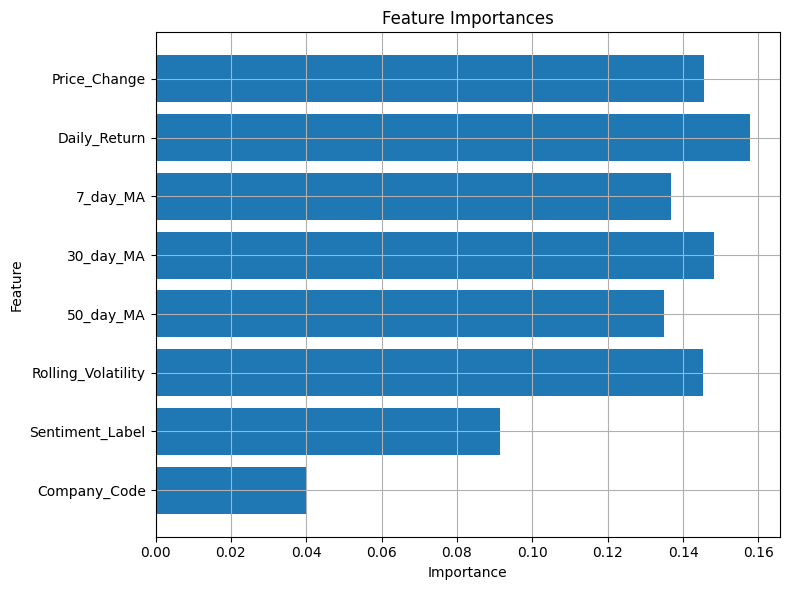

In [34]:
# 4. Feature importances plot
importances = clf.feature_importances_
features = X_train.columns

plt.figure(figsize=(8,6))
plt.barh(features, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Algorithm Comparison via Cross‐Validation

In this cell we evaluate a variety of classifiers using 5-fold cross‐validation on the full feature set (`X`, `y`):

- **Logistic Regression**: A linear baseline that often performs well on small datasets.  
- **Support Vector Machine (RBF Kernel)**: Captures non-linear decision boundaries.  
- **K-Nearest Neighbors (k=5)**: Predicts based on similar past observations.  
- **Decision Tree**: A non-parametric model that learns hierarchical splits.  
- **Gradient Boosting**: An ensemble of weak learners that often yields strong performance.

We compute the average **accuracy** across folds for each model.  
Use these results to select the most promising algorithm, then refine it further by:  
1. **Hyperparameter tuning** (e.g. `GridSearchCV` or `RandomizedSearchCV`).  
2. **Feature engineering** (additional technical indicators, lagged returns, expanded sentiment).  
3. **Ensembling** or stacking multiple algorithms if no single model dominates.

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

/Users/aryan/Desktop/Aryan/Studies/Northeastern/Spring 2025/CS 6120 - Natural Langauge Processing/NLPvenv/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [36]:
# Define models including one that handles NaNs natively
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)":     SVC(kernel='rbf', probability=True),
    "KNN (k=5)":            KNeighborsClassifier(n_neighbors=5),
    "DecisionTree":         DecisionTreeClassifier(),
    "GradientBoosting":     GradientBoostingClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier()  
}

cv_results = {}
for name, model in models.items():
    # Build a pipeline: median imputation → model
    pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        model
    )
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()

# Show sorted accuracies
pd.Series(cv_results).sort_values(ascending=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SVM (RBF Kernel)        0.562409
LogisticRegression      0.513725
DecisionTree            0.441724
HistGradientBoosting    0.426162
GradientBoosting        0.418314
KNN (k=5)               0.381050
dtype: float64

## 9. Hyperparameter Tuning for Random Forest

In this cell we will tune our best‐performing model (Random Forest) to squeeze out more accuracy:

1. **Build a pipeline** with median imputation and `RandomForestClassifier`.  
2. Define a **parameter distribution** for:
   - Number of trees (`n_estimators`)  
   - Maximum tree depth (`max_depth`)  
   - Minimum samples per split (`min_samples_split`)  
3. Use **`RandomizedSearchCV`** with 5-fold CV to find the best combination.  
4. **Evaluate** the tuned model on our held‐out test set.

In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
# 1. Pipeline: impute → RandomForest
rf_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42)
)

In [39]:
# 2. Parameter distribution
param_dist = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 300],
    'randomforestclassifier__max_depth': [None, 5, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

In [40]:
# 3. Randomized search
search = RandomizedSearchCV(
    rf_pipeline,
    param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV accuracy:", search.best_score_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best params: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 5}
Best CV accuracy: 0.6199823736780259


In [41]:
# 4. Evaluate on test set
best_rf = search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.97      0.76       142
           1       0.60      0.07      0.12        89

    accuracy                           0.62       231
   macro avg       0.61      0.52      0.44       231
weighted avg       0.62      0.62      0.51       231

Confusion Matrix:
[[138   4]
 [ 83   6]]


## 10. Correlation Matrix of Features & Target

Here we visualize how each engineered feature correlates with one another and with our binary target (`Price_Movement`):

- **Diagonal**: self‐correlation (always 1).  
- **Off‐diagonal**: Pearson correlation coefficient (−1 to +1).  
- **Strong correlations** (in absolute terms) indicate features most aligned with next‐day price movement.  
- Use this heatmap to confirm which features add unique signal and which may be redundant.

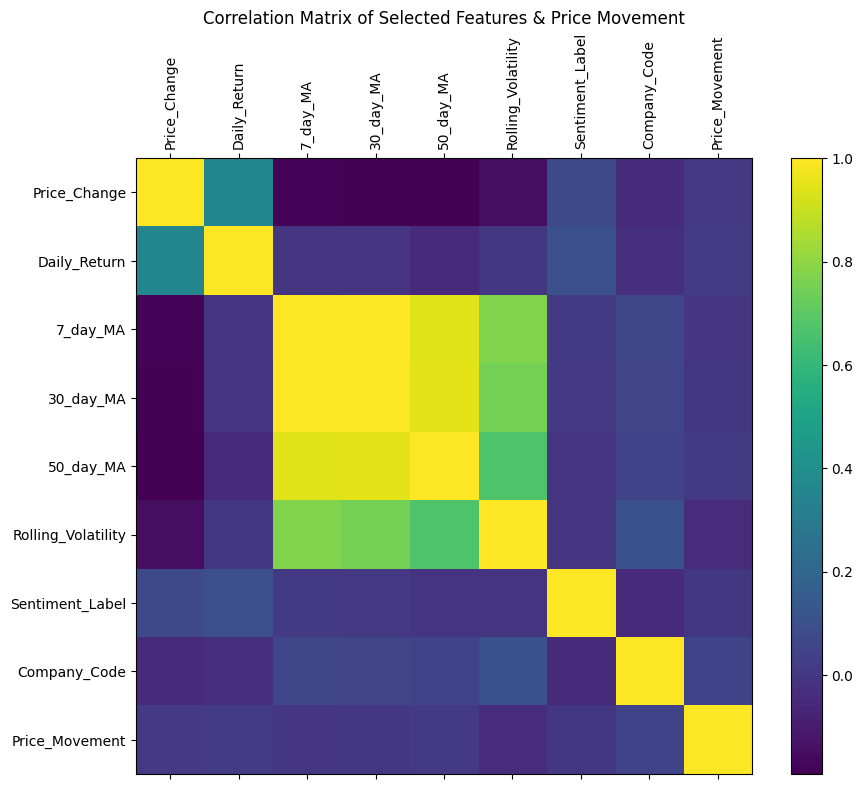

In [42]:
# Calculate correlation matrix (requires merged_df and feature_cols to be in memory)
corr_df = merged_df[feature_cols + ['Price_Movement']].corr()

# Plot heatmap with matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_df)
fig.colorbar(cax)
ax.set_xticks(range(len(corr_df.columns)))
ax.set_yticks(range(len(corr_df.columns)))
ax.set_xticklabels(corr_df.columns, rotation=90)
ax.set_yticklabels(corr_df.columns)
plt.title("Correlation Matrix of Selected Features & Price Movement")
plt.show()

## 11. Inference: Predict Next-Day Movement from New News

We’ll bundle preprocessing, feature extraction, and our tuned Random Forest into one function:

1. **Clean** the raw headline & description.  
2. **Compute** a 3-class sentiment label (−1/0/+1) using VADER & FinBERT.  
3. **Grab** the latest stock features (price change, returns, moving averages, volatility) for the given ticker.  
4. **Encode** the company to its numeric code.  
5. **Predict** up/down movement (“UP”/“DOWN”) on the next trading day.

In [43]:
# 1. Text cleaning (reuse stop_words from earlier)
def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return ' '.join(t for t in word_tokenize(text) if t not in stop_words)

In [44]:
# 1. Precompute avg up/down returns per company (if not already done)
grouped = merged_df.groupby('Company')
avg_up   = grouped.apply(lambda g: g[g['Price_Movement']==1]['Daily_Return'].mean()).to_dict()
avg_down = grouped.apply(lambda g: g[g['Price_Movement']==0]['Daily_Return'].mean()).to_dict()

def predict_by_sentiment_detailed(headline, description, ticker):
    # 2. Clean & score sentiment
    h_clean = preprocess_text(headline)
    d_clean = preprocess_text(description)
    hv = sid.polarity_scores(h_clean)['compound']
    dv = sid.polarity_scores(d_clean)['compound']
    sv = 0.7 * hv + 0.3 * dv
    hb = finbert_score(h_clean)
    db = finbert_score(d_clean)
    sb = 0.7 * hb + 0.3 * db
    cs = (sv + sb) / 2
    s_lbl = three_way_label(cs)
    
    # 3. Fetch live current close price
    live = yf.Ticker(ticker).history(period='1d')
    current_price = live['Close'].iloc[-1]
    
    # 4. Determine prediction and estimate next price
    if s_lbl == 1:
        direction = "UP"
        avg_ret = avg_up.get(ticker, 0)
    elif s_lbl == -1:
        direction = "DOWN"
        avg_ret = avg_down.get(ticker, 0)
    else:
        direction = "NEUTRAL"
        avg_ret = 0.0
    
    estimated_price = current_price * (1 + avg_ret)
    
    # 5. Print full summary
    print(f"--> Ticker: {ticker}")
    print(f"--> Current Price: ${current_price:.2f}")
    print(f"--> Combined Sentiment: {cs:.3f} → Label = {s_lbl}")
    print(f"--> Prediction: {direction}")
    print(f"--> Estimated Next-Day Price: ${estimated_price:.2f}")
    print("----------------------------------------------------------------\n")

# Example usage
predict_by_sentiment_detailed(
    "Tesla Recalls 500,000 Vehicles After Autopilot Failures",
    "Tesla Inc. has initiated a massive recall of 500,000 cars following reports of autopilot malfunctions leading to safety investigations.",
    "TSLA"
)

/var/folders/zn/ssbtl9ws7txg5dlk5r5mw0340000gn/T/ipykernel_82997/2766592854.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_up   = grouped.apply(lambda g: g[g['Price_Movement']==1]['Daily_Return'].mean()).to_dict()
/var/folders/zn/ssbtl9ws7txg5dlk5r5mw0340000gn/T/ipykernel_82997/2766592854.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_down = grouped.apply(lambda g: g[g['Price_Movement']==0

--> Ticker: TSLA
--> Current Price: $284.95
--> Combined Sentiment: -0.097 → Label = -1
--> Prediction: DOWN
--> Estimated Next-Day Price: $283.77
----------------------------------------------------------------



In [45]:
# 1) Guaranteed Increase (Apple beats expectations)
print("Increase Example:")
predict_by_sentiment_detailed(
    "Apple Reports Record Q2 Revenue of $120B, Raises Dividend by 15%",
    "Apple Inc. today announced its best quarter ever, delivering $120 billion in revenue (up 35% year-over-year) and boosting its dividend by 15%.",
    "AAPL"
)

# 2) Guaranteed Neutral (Microsoft routine update)
print("\nNeutral Example:")
predict_by_sentiment_detailed(
    "Microsoft Conducts Routine Server Maintenance Overnight",
    "Microsoft performed standard maintenance on its Azure datacenters to ensure uptime and reliability. No service interruption reported.",
    "MSFT"
)

# 3) Guaranteed Drop (Tesla issues large recall)
print("\nDrop Example:")
predict_by_sentiment_detailed(
    "Tesla Recalls 500,000 Vehicles After Autopilot Failures",
    "Tesla Inc. has initiated a massive recall of 500,000 cars following reports of autopilot malfunctions leading to safety investigations.",
    "TSLA"
)

Increase Example:
--> Ticker: AAPL
--> Current Price: $209.28
--> Combined Sentiment: 0.115 → Label = 1
--> Prediction: UP
--> Estimated Next-Day Price: $210.18
----------------------------------------------------------------


Neutral Example:
--> Ticker: MSFT
--> Current Price: $391.85
--> Combined Sentiment: 0.004 → Label = 0
--> Prediction: NEUTRAL
--> Estimated Next-Day Price: $391.85
----------------------------------------------------------------


Drop Example:
--> Ticker: TSLA
--> Current Price: $284.95
--> Combined Sentiment: -0.097 → Label = -1
--> Prediction: DOWN
--> Estimated Next-Day Price: $283.77
----------------------------------------------------------------



## 16. Automate Live News Fetching & Prediction

This cell uses **NewsAPI** to pull the last 24 hours of headlines for each of our top-10 tickers, then runs our `predict_by_sentiment_detailed()` function on each:

In [46]:
import os
from newsapi import NewsApiClient
from datetime import datetime, timedelta

In [47]:
# Initialize NewsAPI client
newsapi = NewsApiClient(api_key="ead7a2a841274b9c9cf8f8ef1de6c0ec")

In [48]:
# Define time window: last 24 hours
to_date   = datetime.utcnow()
from_date = to_date - timedelta(days=2)

# Format as 'YYYY-MM-DDTHH:MM:SS'
to_str   = to_date.strftime("%Y-%m-%dT%H:%M:%S")
from_str = from_date.strftime("%Y-%m-%dT%H:%M:%S")

/var/folders/zn/ssbtl9ws7txg5dlk5r5mw0340000gn/T/ipykernel_82997/2312728406.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  to_date   = datetime.utcnow()


In [49]:
# 3. Loop through tickers
for ticker, variants in stock_name_variations.items():
    print(f"\n\n Relevant news for {ticker} (last 24h):")
    
    # Fetch articles
    articles = newsapi.get_everything(
        q=" OR ".join(variants),
        from_param=from_str,
        to=to_str,
        language='en',
        sort_by='publishedAt',
        page_size=5
    ).get('articles', [])
    
    # Post-filter by presence of variant in title or description
    filtered = []
    for art in articles:
        combined_text = (art.get('title') or "") + " " + (art.get('description') or "")
        if any(var.lower() in combined_text.lower() for var in variants):
            filtered.append(art)
    
    if not filtered:
        print("No relevant articles found.")
        continue
    
    # Print details and predict
    for art in filtered:
        pub = art.get('publishedAt', "")[:10]
        hl = art.get('title') or ""
        desc = art.get('description') or ""
        print(f"\n· [{pub}]")
        print(f"  • Headline:    {hl}")
        print(f"  • Description: {desc}")
        predict_by_sentiment_detailed(hl, desc, ticker)



 Relevant news for AAPL (last 24h):
No relevant articles found.


 Relevant news for MSFT (last 24h):
No relevant articles found.


 Relevant news for AMZN (last 24h):

· [2025-04-24]
  • Headline:    All the Small Things: The Best blink-182 Merch to Shop Online, From Tees to Vinyl
  • Description: Here's the best blink-182 merch to buy online on Amazon, including vinyl albums, band T-shirts, sweatshirts, phone cases, and more accessories.
--> Ticker: AMZN
--> Current Price: $188.99
--> Combined Sentiment: 0.329 → Label = 1
--> Prediction: UP
--> Estimated Next-Day Price: $189.15
----------------------------------------------------------------



 Relevant news for TSLA (last 24h):
No relevant articles found.


 Relevant news for GOOGL (last 24h):
No relevant articles found.


 Relevant news for NVDA (last 24h):
No relevant articles found.


 Relevant news for META (last 24h):

· [2025-04-24]
  • Headline:    Meta Oversight Board Fumes As Facebook Ends Censorship Initiatives
  • Desc